# Lesson 7: Chatting with the SEC Knowledge Graph

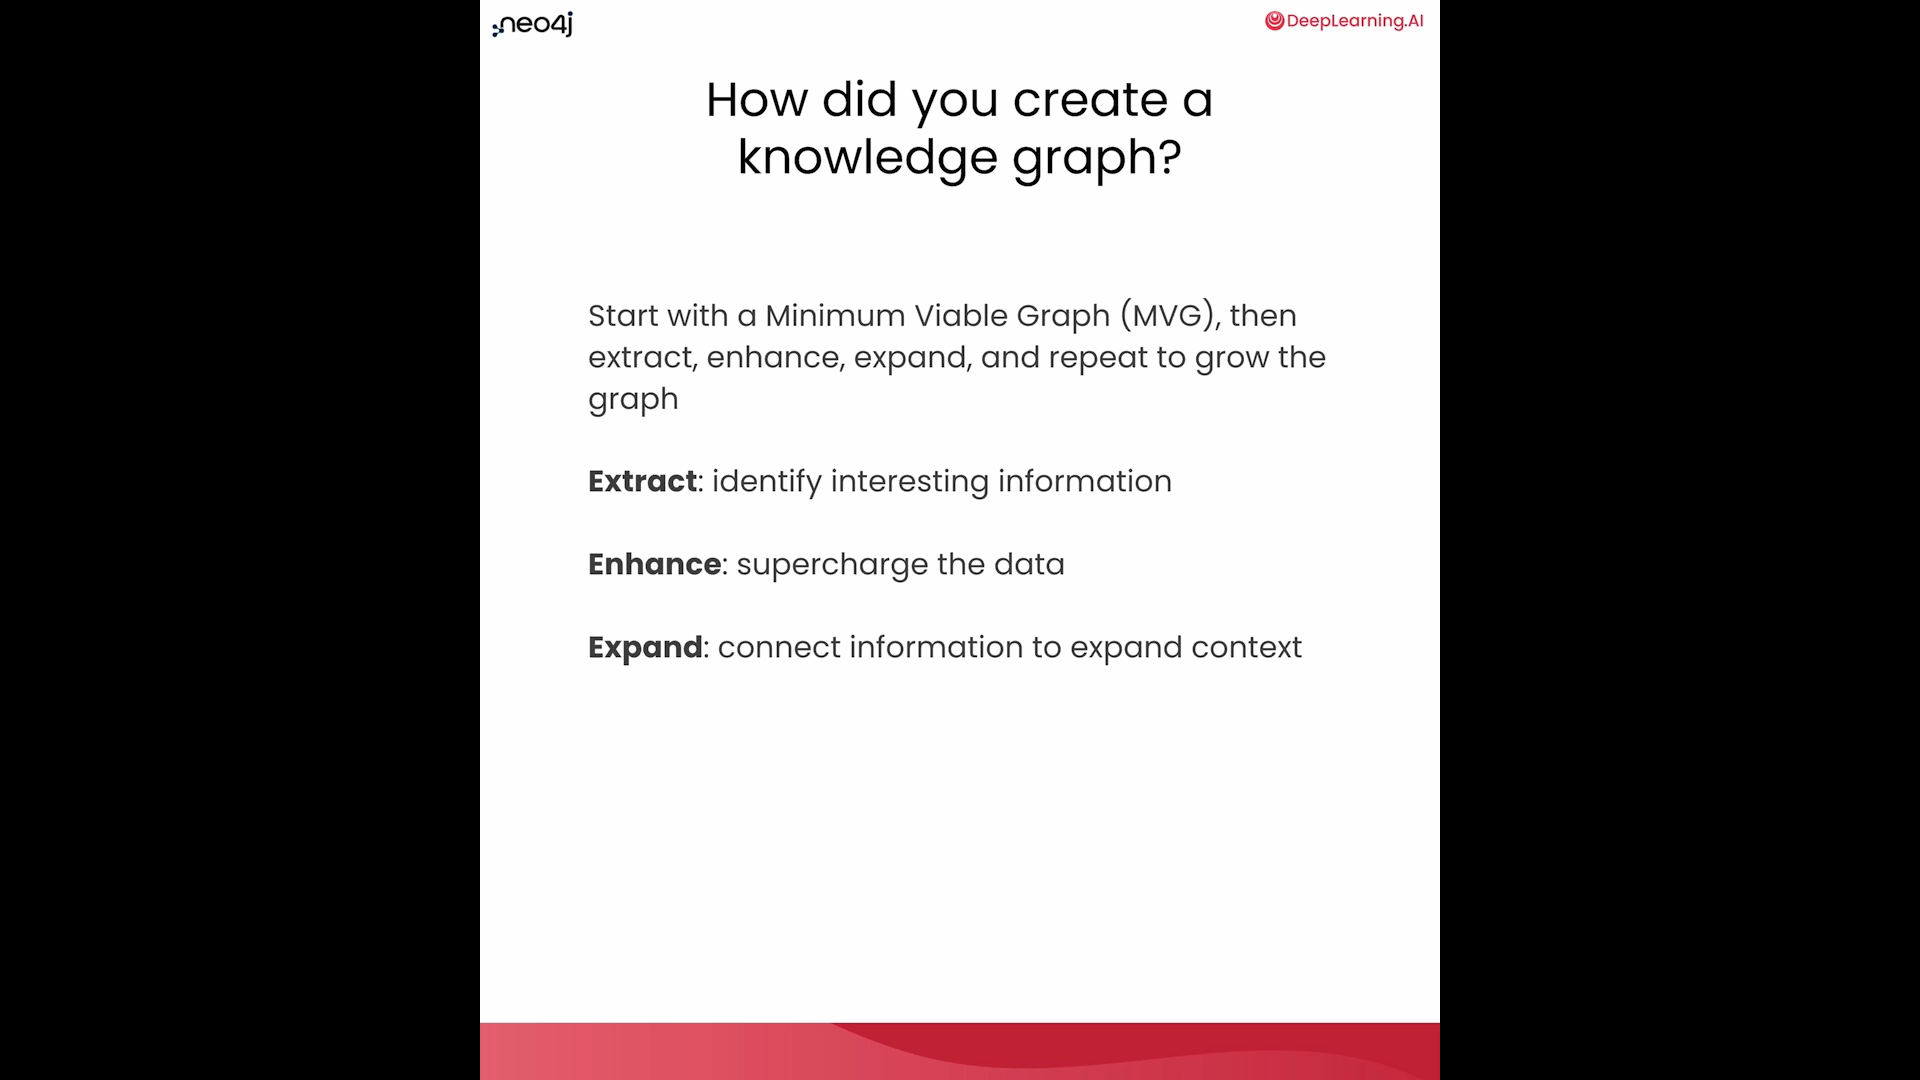

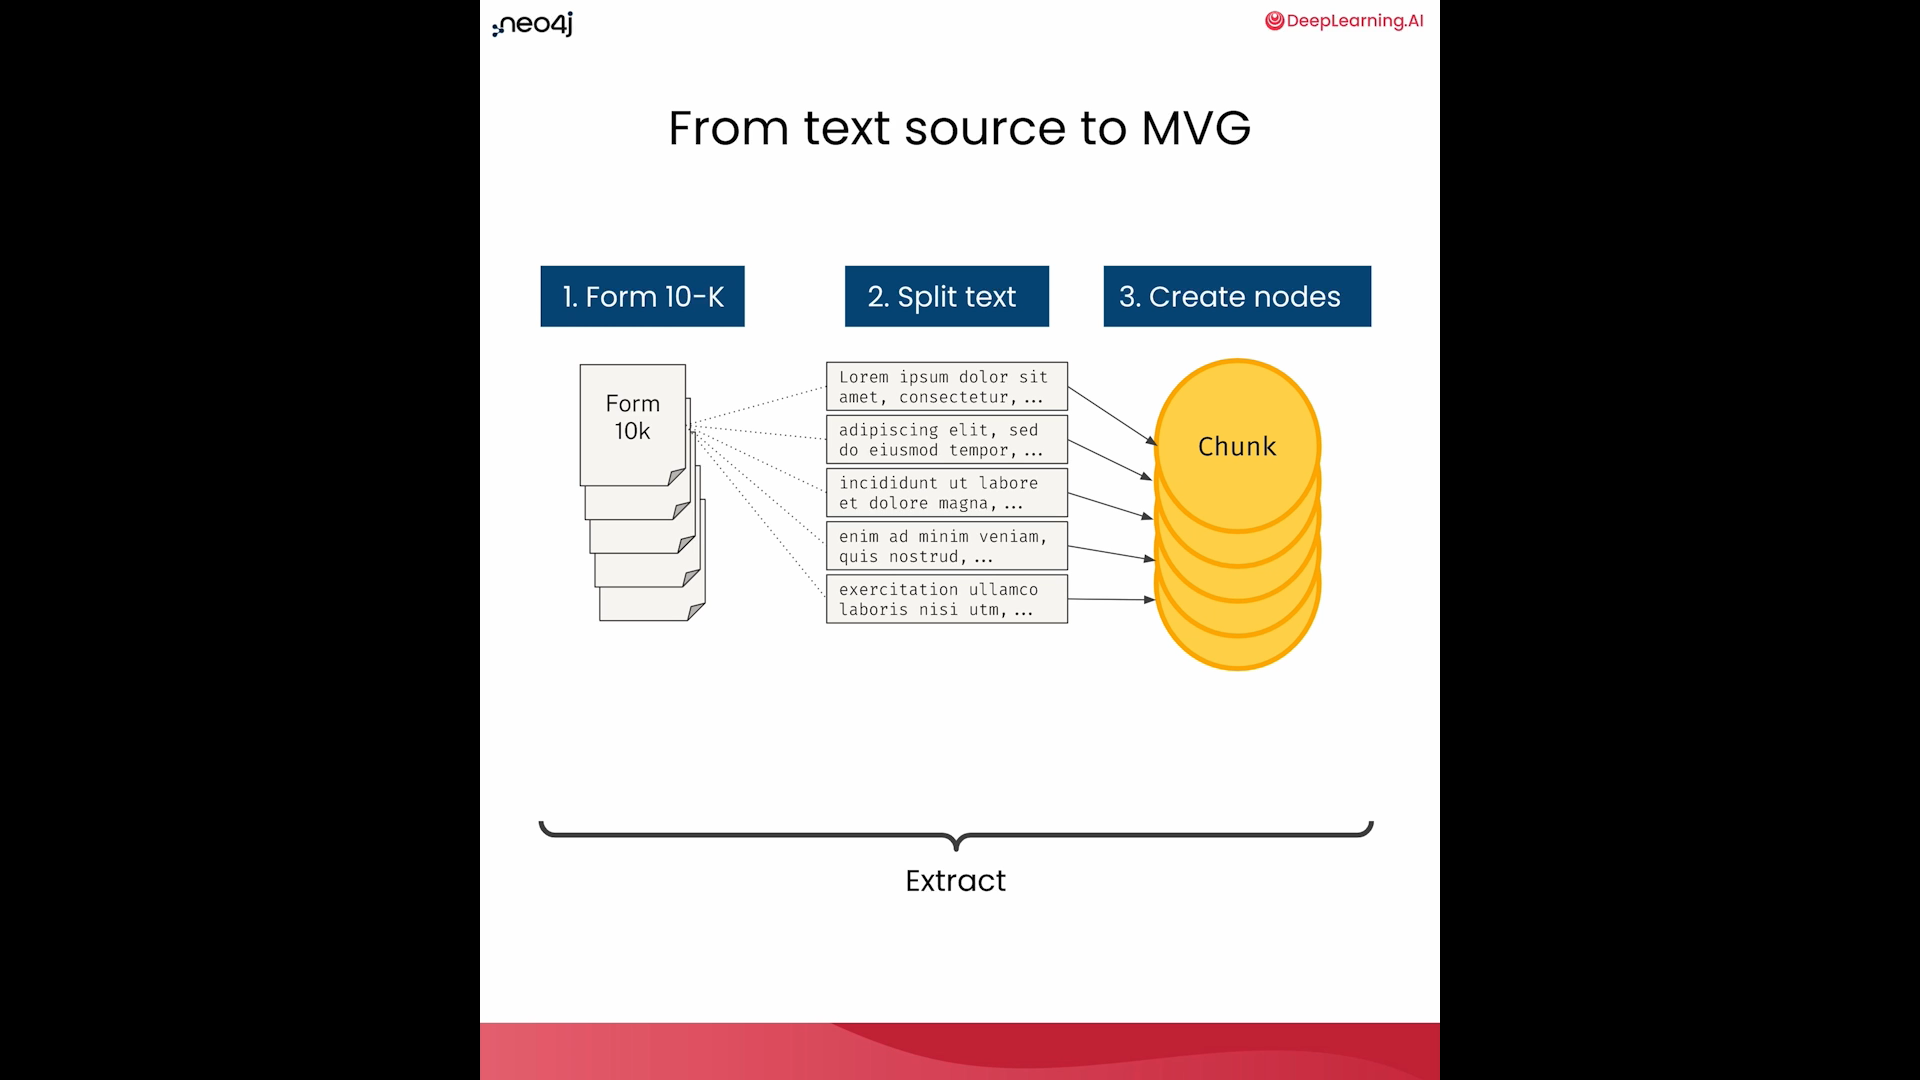

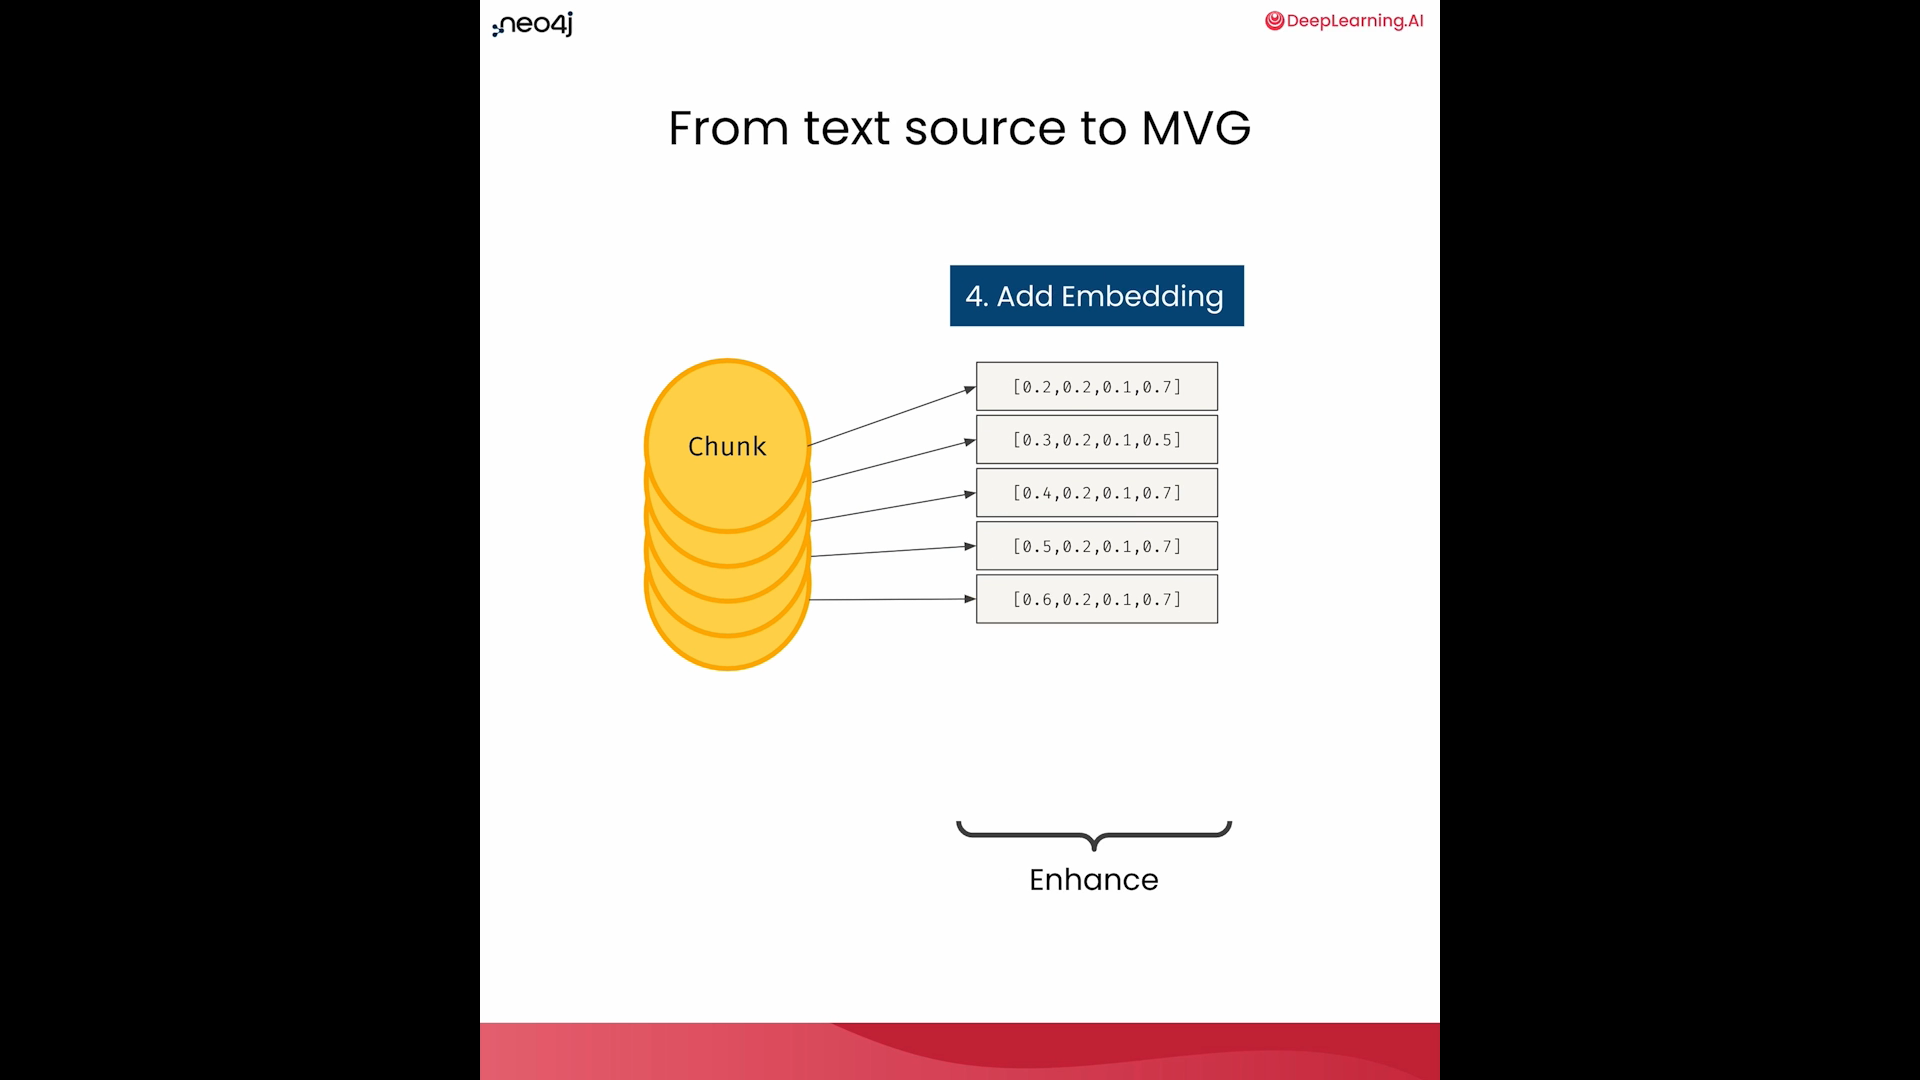

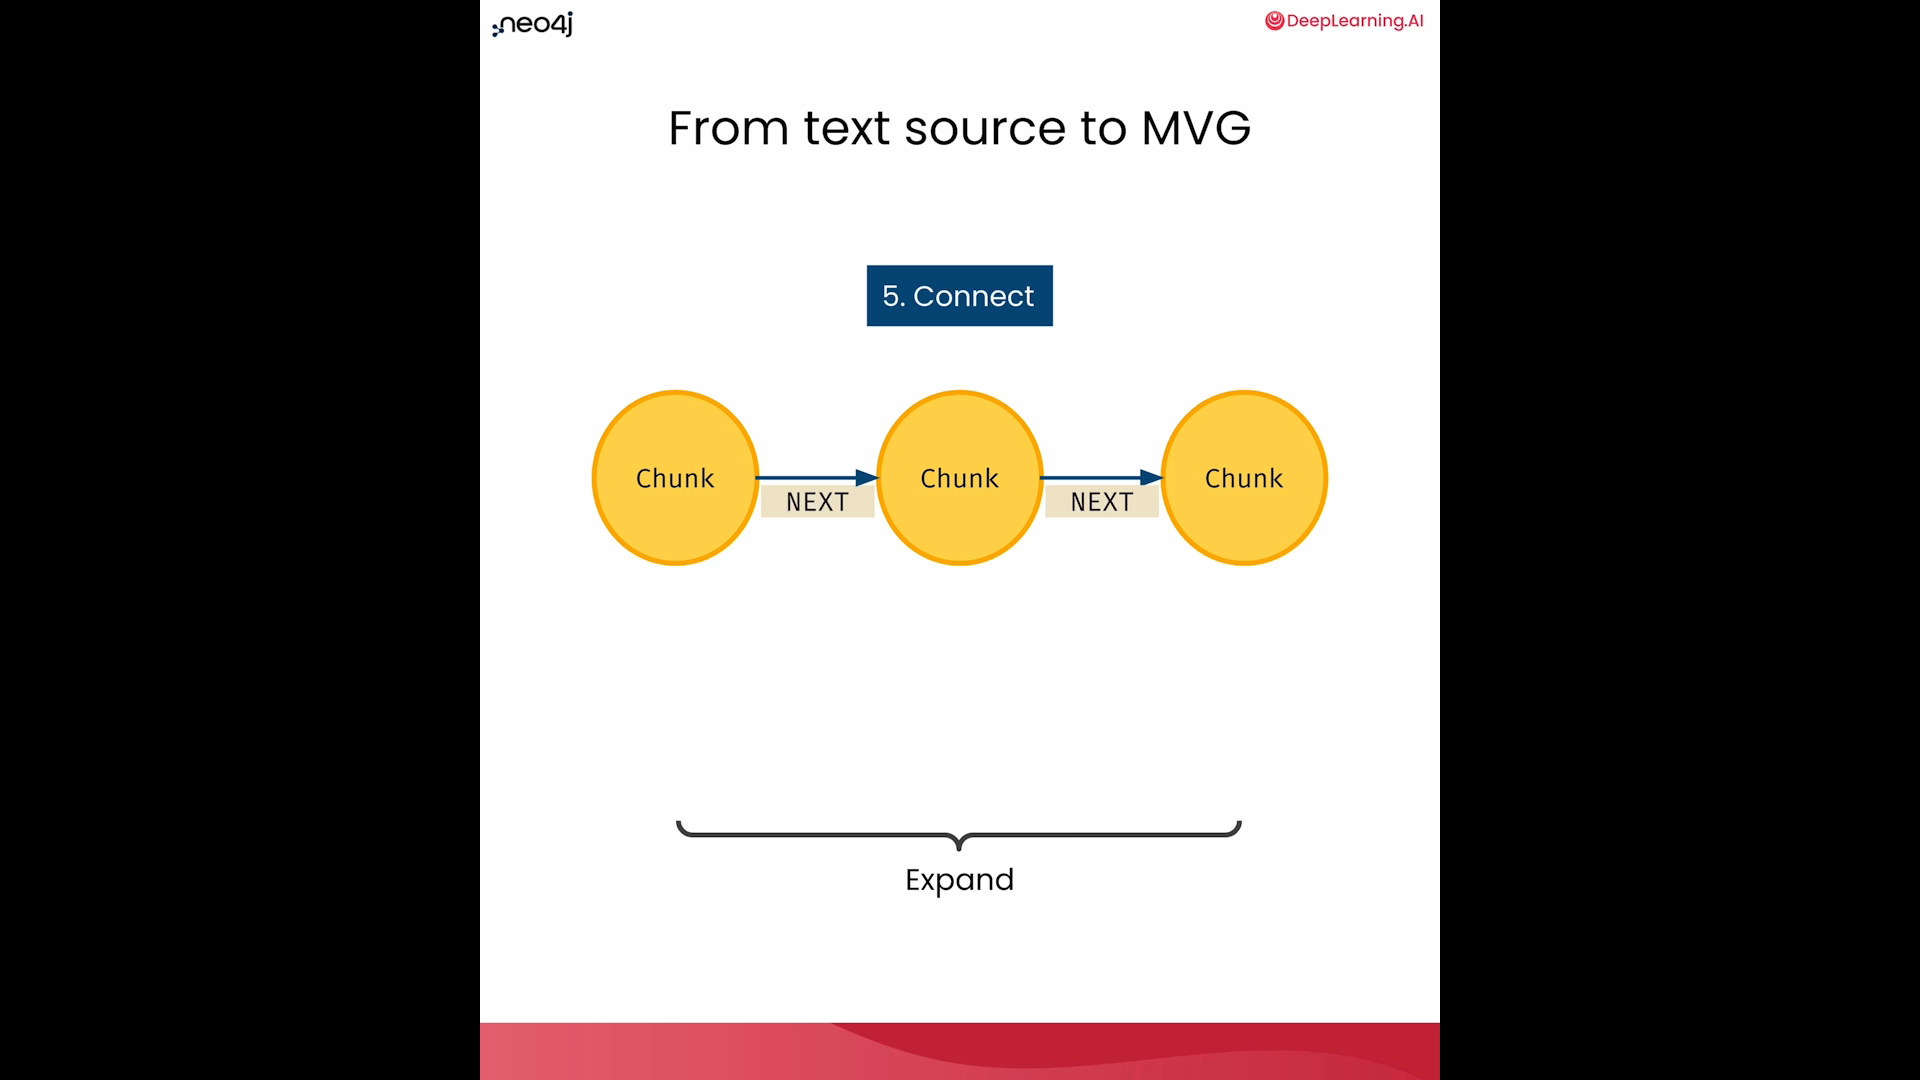

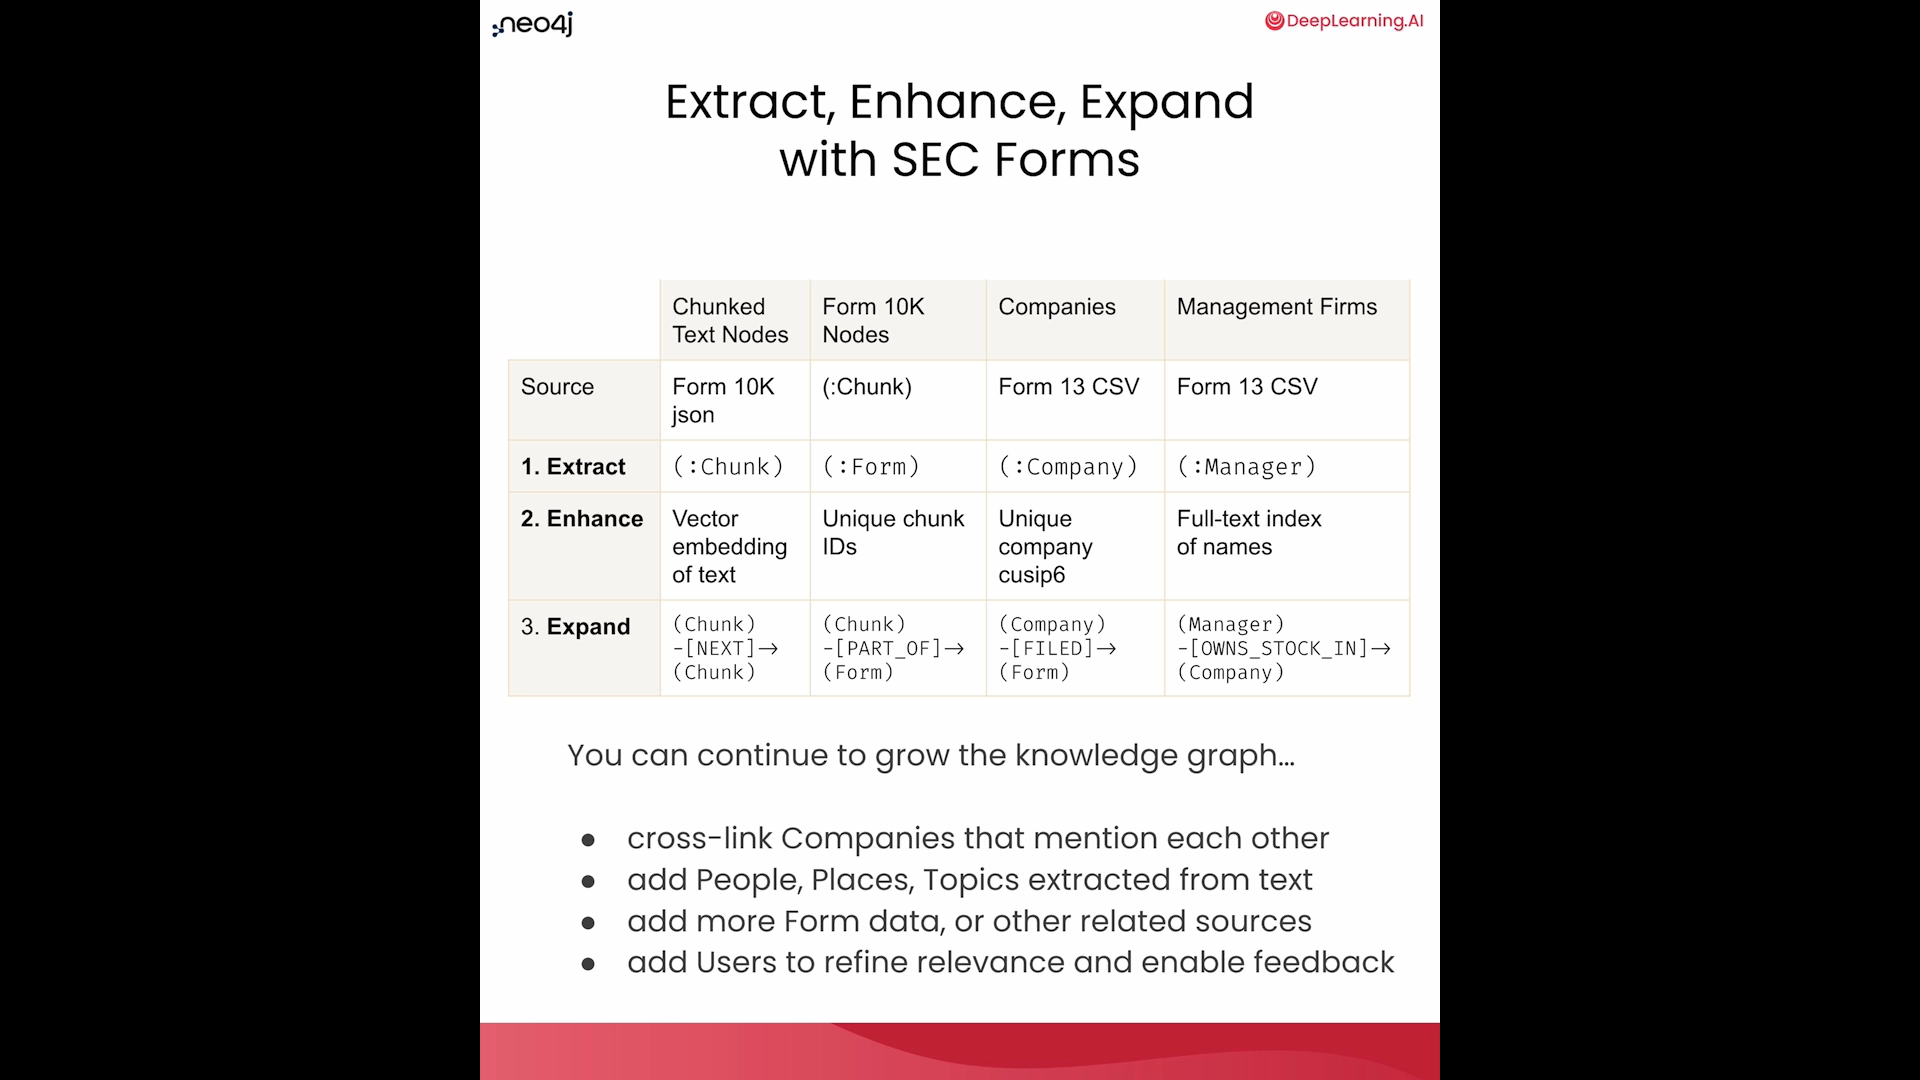

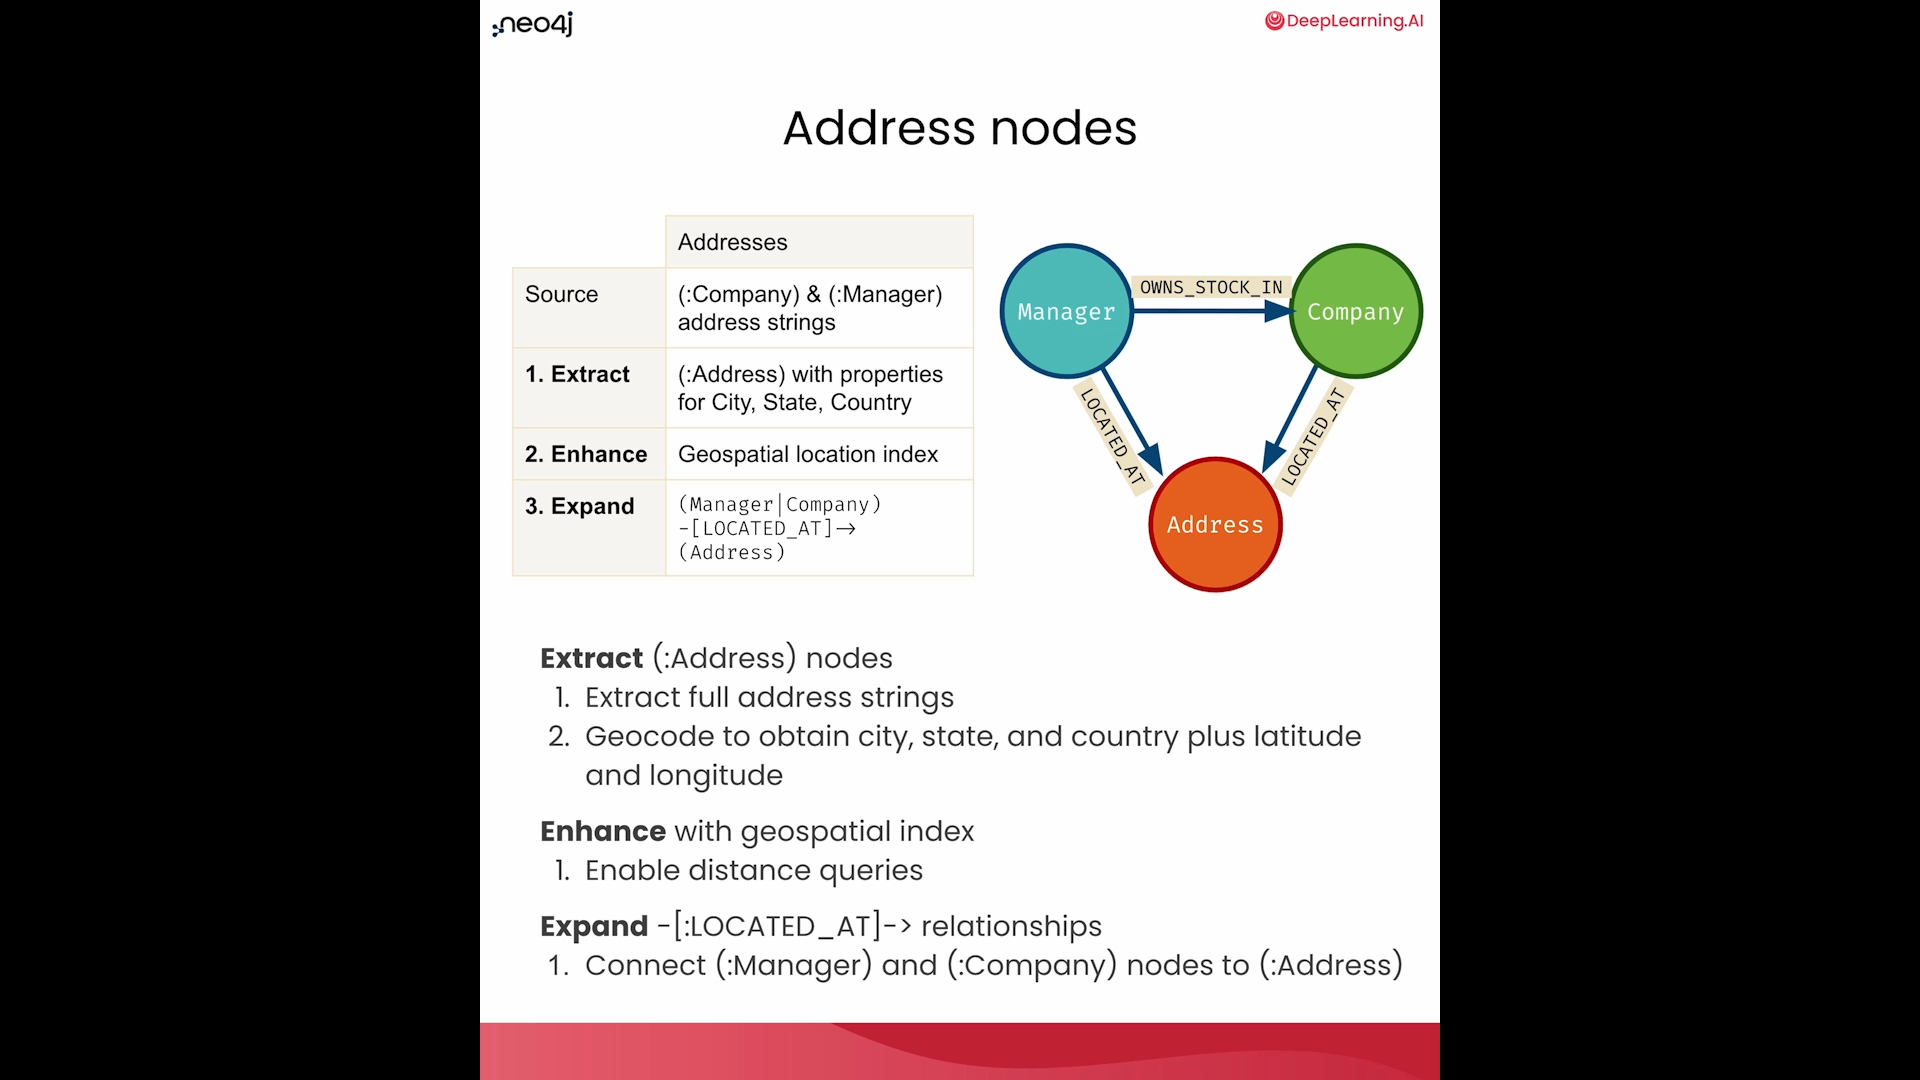

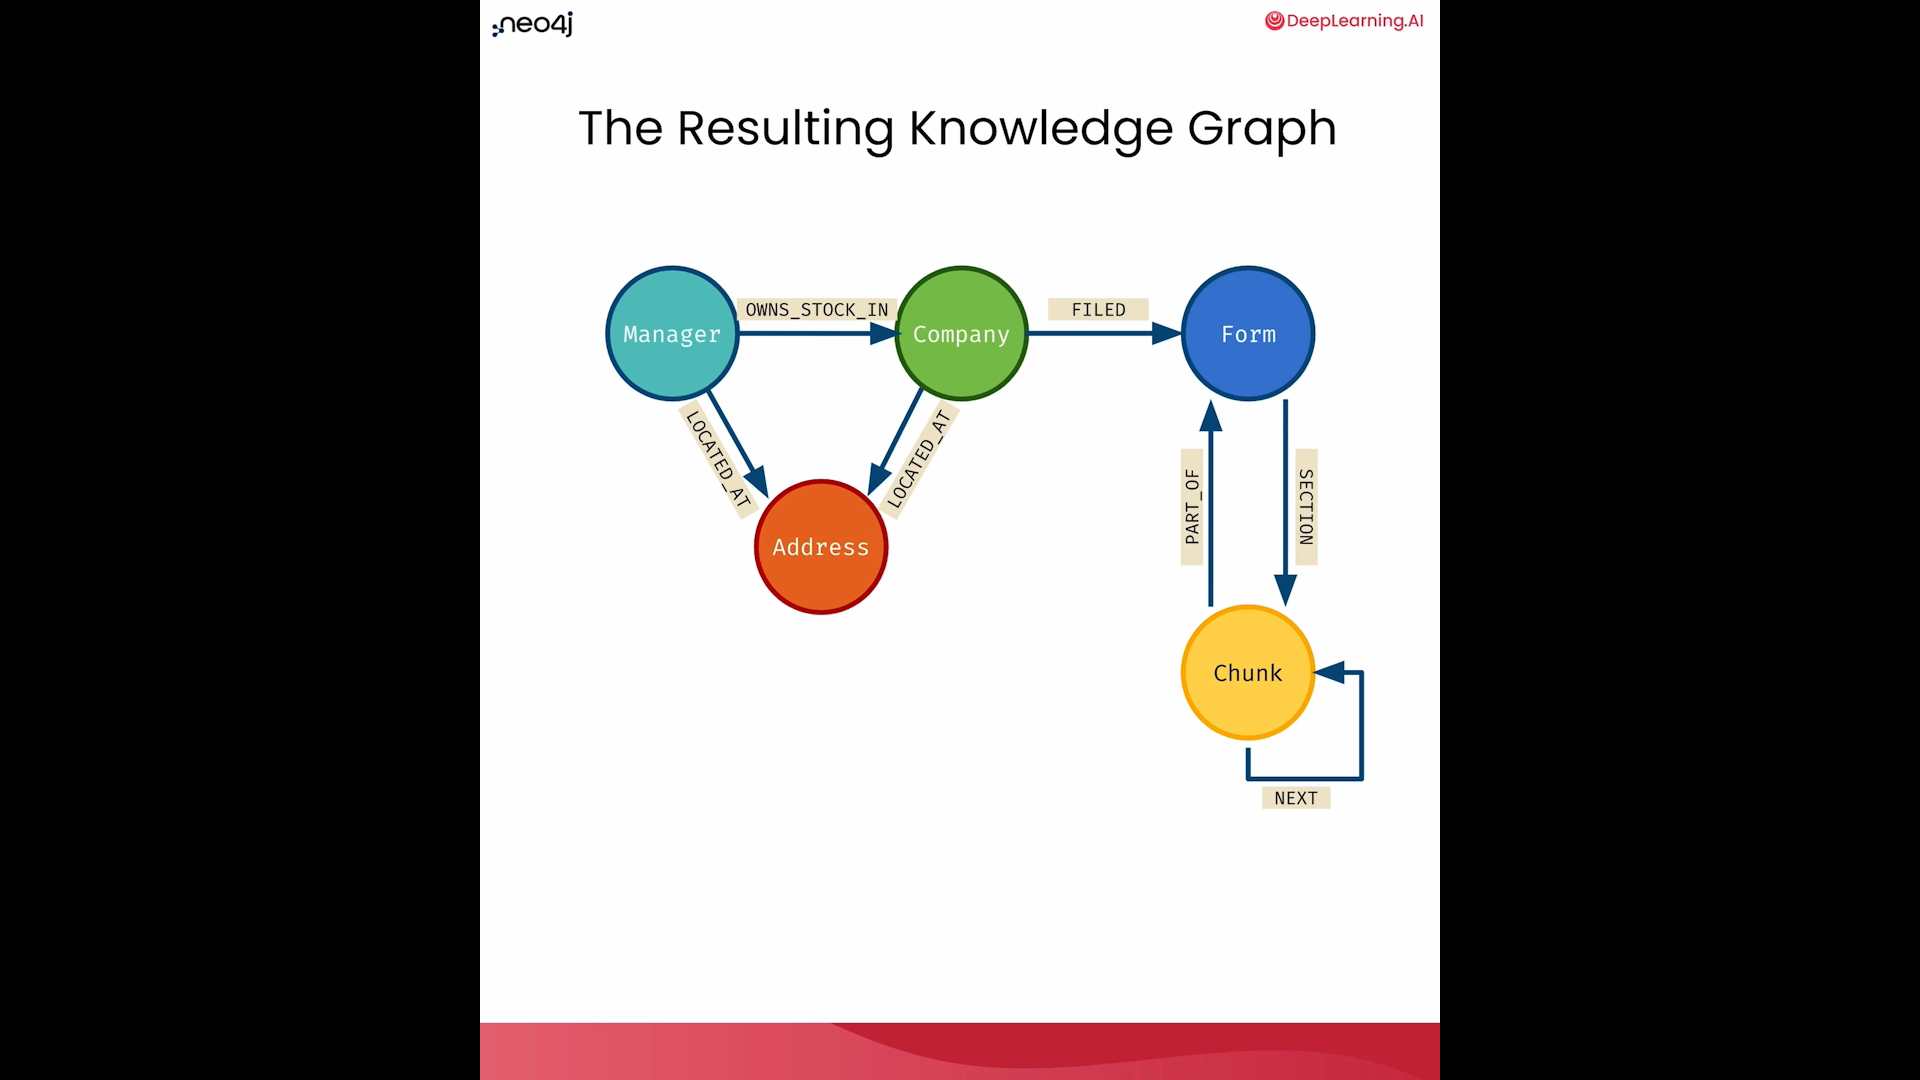

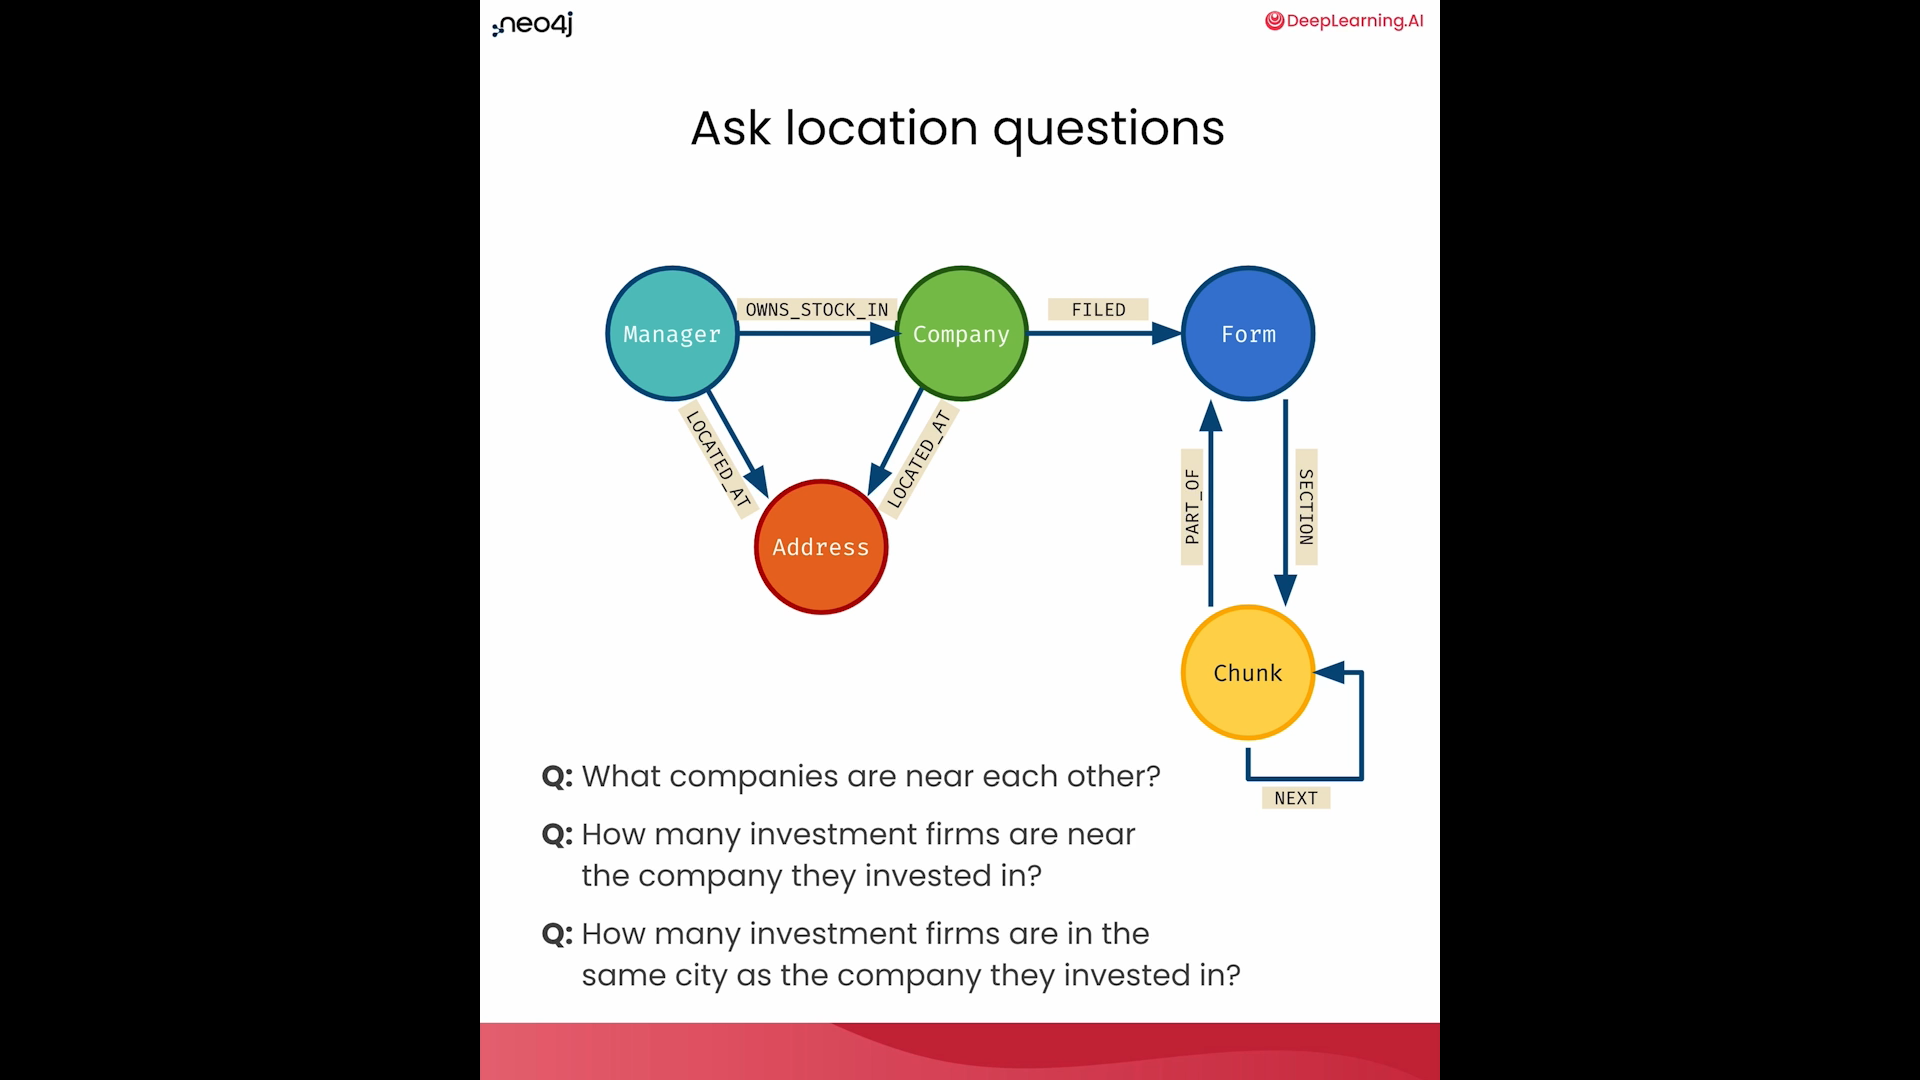

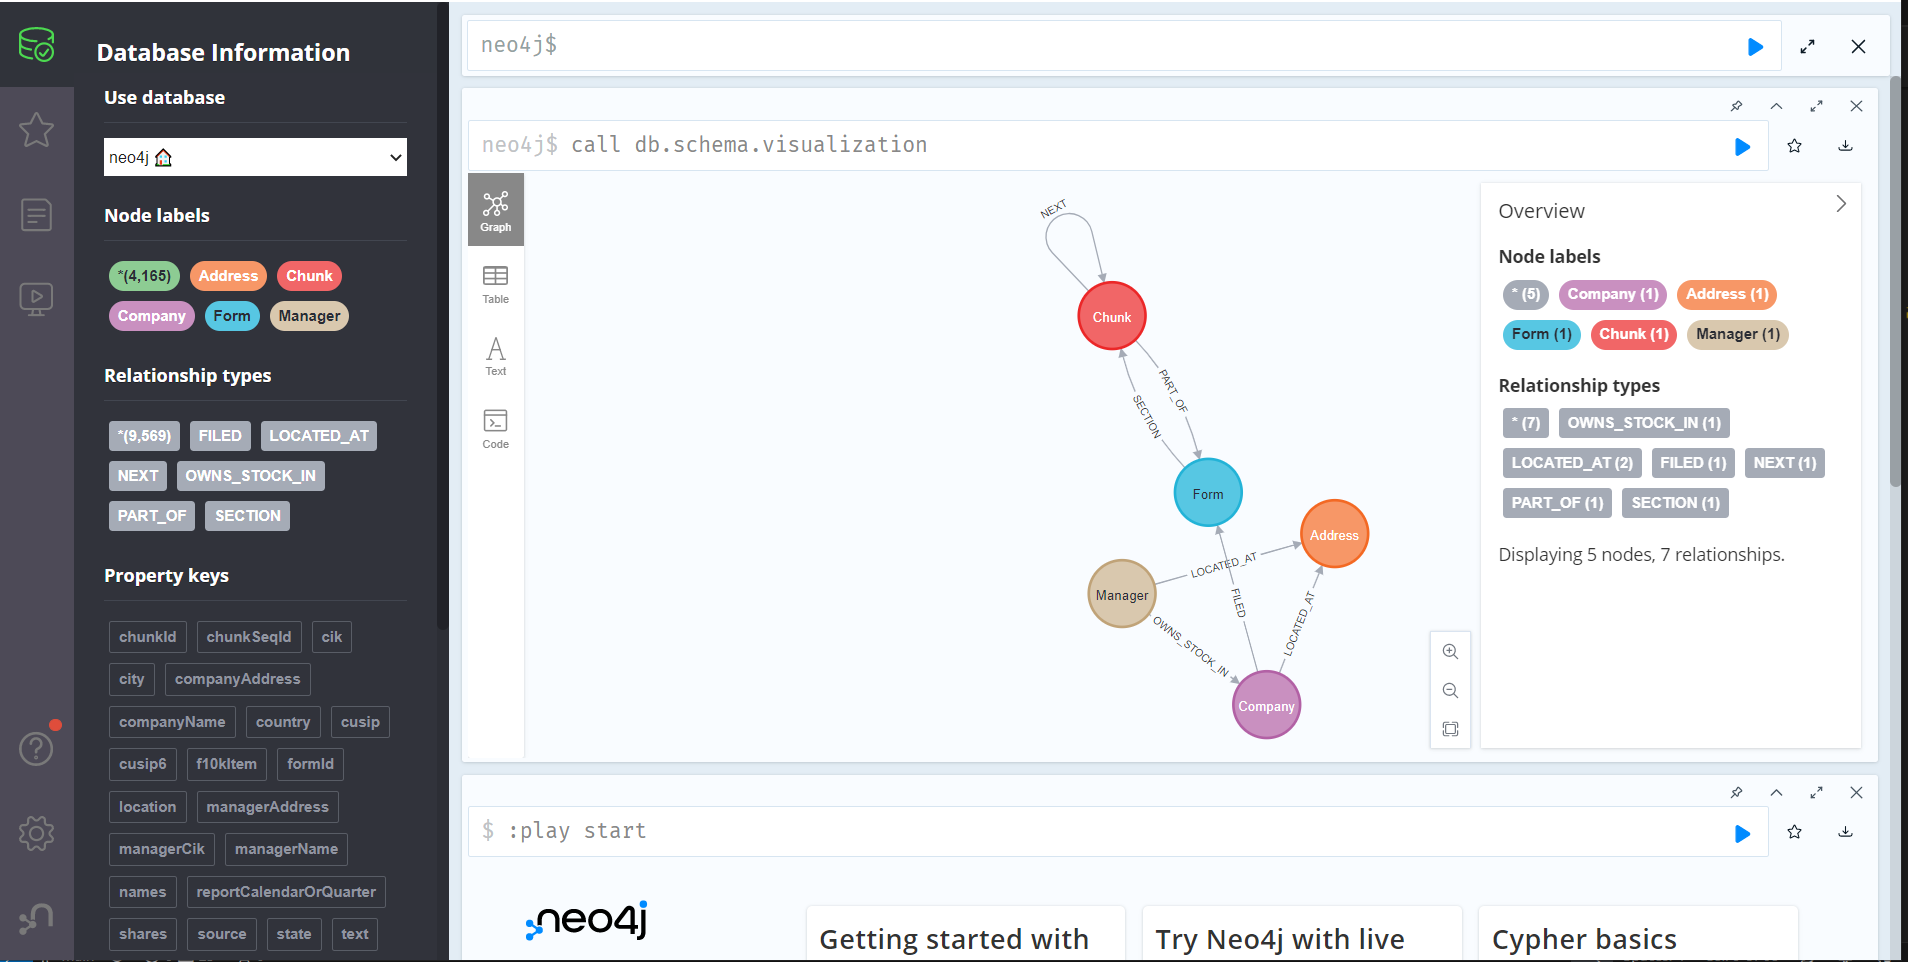

<p style="background-color:#fd4a6180; padding:15px; margin-left:20px"> <b>Note:</b> This notebook takes about 30 seconds to be ready to use. Please wait until the "Kernel starting, please wait..." message clears from the top of the notebook before running any cells. You may start the video while you wait.</p>

### Import packages and set up Neo4j

In [1]:
from dotenv import load_dotenv
import os

import textwrap

# Langchain
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.prompts.prompt import PromptTemplate
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI

# Warning control
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load from environment
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE') or 'neo4j'
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Note the code below is unique to this course environment, and not a 
# standard part of Neo4j's integration with OpenAI. Remove if running 
# in your own environment.
OPENAI_ENDPOINT = os.getenv('OPENAI_BASE_URL') + '/embeddings'

# Global constants
VECTOR_INDEX_NAME = 'form_10k_chunks'
VECTOR_NODE_LABEL = 'Chunk'
VECTOR_SOURCE_PROPERTY = 'text'
VECTOR_EMBEDDING_PROPERTY = 'textEmbedding'

In [3]:
kg = Neo4jGraph(
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE
)

### Explore the updated SEC documents graph
In this lesson, you'll be working with an updated graph that also includes the address information discussed in the video
- Some outputs below may differ slightly from the video
- Start by checking the schema of the graph

In [4]:
kg.refresh_schema()
print(textwrap.fill(kg.schema, 60))

Node properties are the following: Chunk {textEmbedding:
LIST, f10kItem: STRING, chunkSeqId: INTEGER, text: STRING,
cik: STRING, cusip6: STRING, names: LIST, formId: STRING,
source: STRING, chunkId: STRING},Form {cusip6: STRING,
names: LIST, formId: STRING, source: STRING},Company
{location: POINT, cusip: STRING, names: LIST,
companyAddress: STRING, companyName: STRING, cusip6:
STRING},Manager {location: POINT, managerName: STRING,
managerCik: STRING, managerAddress: STRING},Address
{location: POINT, country: STRING, city: STRING, state:
STRING} Relationship properties are the following: SECTION
{f10kItem: STRING},OWNS_STOCK_IN {shares: INTEGER,
reportCalendarOrQuarter: STRING, value: FLOAT} The
relationships are the following: (:Chunk)-[:NEXT]-
>(:Chunk),(:Chunk)-[:PART_OF]->(:Form),(:Form)-[:SECTION]-
>(:Chunk),(:Company)-[:FILED]->(:Form),(:Company)-
[:LOCATED_AT]->(:Address),(:Manager)-[:LOCATED_AT]-
>(:Address),(:Manager)-[:OWNS_STOCK_IN]->(:Company)


- Check the address of a random Manager
- Note: the company returned by the following query may differ from the one in the video

In [5]:
kg.query("""
MATCH (mgr:Manager)-[:LOCATED_AT]->(addr:Address)
RETURN mgr, addr
LIMIT 1
""")

[{'mgr': {'managerCik': '1424381',
   'managerAddress': '650 Madison Avenue, 25th Floor, New York, NY, 10022',
   'location': POINT(-73.9713457 40.7639879),
   'managerName': 'LAKEWOOD CAPITAL MANAGEMENT, LP'},
  'addr': {'country': 'United States',
   'city': 'New York',
   'location': POINT(-73.9821429 40.7584882),
   'state': 'New York'}}]

- Full text search for a manager named Royal Bank

In [6]:
kg.query("""
  CALL db.index.fulltext.queryNodes(
         "fullTextManagerNames", 
         "royal bank") YIELD node, score
  RETURN node.managerName, score LIMIT 1
""")

[{'node.managerName': 'Royal Bank of Canada', 'score': 4.431276321411133}]

- Find location of Royal Bank

In [7]:
kg.query("""
CALL db.index.fulltext.queryNodes(
         "fullTextManagerNames", 
         "royal bank"
  ) YIELD node, score
WITH node as mgr LIMIT 1
MATCH (mgr:Manager)-[:LOCATED_AT]->(addr:Address)
RETURN mgr.managerName, addr
""")

[{'mgr.managerName': 'Royal Bank of Canada',
  'addr': {'country': 'Canada',
   'city': 'Toronto',
   'location': POINT(-79.3805647 43.6508267),
   'state': 'Ontario'}}]

- Determine which state has the most investment firms

In [8]:
kg.query("""
  MATCH p=(:Manager)-[:LOCATED_AT]->(address:Address)
  RETURN address.state as state, count(address.state) as numManagers
    ORDER BY numManagers DESC
    LIMIT 10
""")

[{'state': 'New York', 'numManagers': 304},
 {'state': 'California', 'numManagers': 302},
 {'state': 'Massachusetts', 'numManagers': 146},
 {'state': 'Pennsylvania', 'numManagers': 138},
 {'state': 'Texas', 'numManagers': 125},
 {'state': 'Illinois', 'numManagers': 121},
 {'state': 'Florida', 'numManagers': 115},
 {'state': 'Connecticut', 'numManagers': 77},
 {'state': 'Ohio', 'numManagers': 76},
 {'state': 'New Jersey', 'numManagers': 69}]

- Determine which state has the most companies

In [9]:
kg.query("""
  MATCH p=(:Company)-[:LOCATED_AT]->(address:Address)
  RETURN address.state as state, count(address.state) as numCompanies
    ORDER BY numCompanies DESC
""")

[{'state': 'California', 'numCompanies': 7},
 {'state': 'Delaware', 'numCompanies': 1},
 {'state': 'New York', 'numCompanies': 1},
 {'state': 'Oregon', 'numCompanies': 1}]

- What are the cities in California with the most investment firms?

In [10]:
kg.query("""
  MATCH p=(:Manager)-[:LOCATED_AT]->(address:Address)
         WHERE address.state = 'California'
  RETURN address.city as city, count(address.city) as numManagers
    ORDER BY numManagers DESC
    LIMIT 10
""")

[{'city': 'San Francisco', 'numManagers': 48},
 {'city': 'Los Angeles', 'numManagers': 44},
 {'city': 'San Diego', 'numManagers': 17},
 {'city': 'Pasadena', 'numManagers': 13},
 {'city': 'Menlo Park', 'numManagers': 9},
 {'city': 'Newport Beach', 'numManagers': 9},
 {'city': 'Irvine', 'numManagers': 9},
 {'city': 'Walnut Creek', 'numManagers': 8},
 {'city': 'Palo Alto', 'numManagers': 6},
 {'city': 'Lafayette', 'numManagers': 6}]

- Which city in California has the most companies listed?

In [11]:
kg.query("""
  MATCH p=(:Company)-[:LOCATED_AT]->(address:Address)
         WHERE address.state = 'California'
  RETURN address.city as city, count(address.city) as numCompanies
    ORDER BY numCompanies DESC
""")

[{'city': 'Santa Clara', 'numCompanies': 3},
 {'city': 'San Jose', 'numCompanies': 2},
 {'city': 'Sunnyvale', 'numCompanies': 1},
 {'city': 'Cupertino', 'numCompanies': 1}]

- What are top investment firms in San Francisco?

In [12]:
kg.query("""
  MATCH p=(mgr:Manager)-[:LOCATED_AT]->(address:Address),
         (mgr)-[owns:OWNS_STOCK_IN]->(:Company)
         WHERE address.city = "San Francisco"
  RETURN mgr.managerName, sum(owns.value) as totalInvestmentValue
    ORDER BY totalInvestmentValue DESC
    LIMIT 10
""")

[{'mgr.managerName': 'Dodge & Cox', 'totalInvestmentValue': 3889236092000.0},
 {'mgr.managerName': 'WELLS FARGO & COMPANY/MN',
  'totalInvestmentValue': 2177580039000.0},
 {'mgr.managerName': 'CHARLES SCHWAB INVESTMENT MANAGEMENT INC',
  'totalInvestmentValue': 1944847519000.0},
 {'mgr.managerName': 'Parallax Volatility Advisers, L.P.',
  'totalInvestmentValue': 694023723000.0},
 {'mgr.managerName': 'PARNASSUS INVESTMENTS, LLC',
  'totalInvestmentValue': 211068925000.0},
 {'mgr.managerName': 'Spyglass Capital Management LLC',
  'totalInvestmentValue': 98135259000.0},
 {'mgr.managerName': 'Valiant Capital Management, L.P.',
  'totalInvestmentValue': 52124040000.0},
 {'mgr.managerName': 'Ensemble Capital Management, LLC',
  'totalInvestmentValue': 42355370000.0},
 {'mgr.managerName': 'Woodline Partners LP',
  'totalInvestmentValue': 41497384000.0},
 {'mgr.managerName': 'Alta Park Capital, LP',
  'totalInvestmentValue': 38959909000.0}]

- What companies are located in Santa Clara?

In [13]:
kg.query("""
  MATCH (com:Company)-[:LOCATED_AT]->(address:Address)
         WHERE address.city = "Santa Clara"
  RETURN com.companyName
""")

[{'com.companyName': 'PALO ALTO NETWORKS INC'},
 {'com.companyName': 'SEAGATE TECHNOLOGY'},
 {'com.companyName': 'ATLASSIAN CORP PLC'}]

- What companies are near Santa Clara?

In [14]:
kg.query("""
  MATCH (sc:Address)
    WHERE sc.city = "Santa Clara"
  MATCH (com:Company)-[:LOCATED_AT]->(comAddr:Address)
    WHERE point.distance(sc.location, comAddr.location) < 10000
  RETURN com.companyName, com.companyAddress
""")

[{'com.companyName': 'PALO ALTO NETWORKS INC',
  'com.companyAddress': '3000 Tannery Way, Santa Clara, CA 95054, USA'},
 {'com.companyName': 'GSI TECHNOLOGY INC',
  'com.companyAddress': '1213 Elko Dr, Sunnyvale, CA 94089, USA'},
 {'com.companyName': 'SEAGATE TECHNOLOGY',
  'com.companyAddress': '2445 Augustine Dr, Santa Clara, CA 95054, USA'},
 {'com.companyName': 'ATLASSIAN CORP PLC',
  'com.companyAddress': '431 El Camino Real, Santa Clara, CA 95050, USA'},
 {'com.companyName': 'APPLE INC', 'com.companyAddress': 'Cupertino, CA, USA'}]

- What investment firms are near Santa Clara?
- Try updating the distance in the query to expand the search radius

In [15]:
kg.query("""
  MATCH (address:Address)
    WHERE address.city = "Santa Clara"
  MATCH (mgr:Manager)-[:LOCATED_AT]->(managerAddress:Address)
    WHERE point.distance(address.location, 
        managerAddress.location) < 10000
  RETURN mgr.managerName, mgr.managerAddress
""")

[{'mgr.managerName': 'Mine & Arao Wealth Creation & Management, LLC.',
  'mgr.managerAddress': '901 CAMPISI WAY, SUITE 140, CAMPBELL, CA, 95008'}]

- Which investment firms are near Palo Alto Networks?
- Note that full-text search is able to handle typos!

In [16]:
# Which investment firms are near Palo Aalto Networks?
kg.query("""
  CALL db.index.fulltext.queryNodes(
         "fullTextCompanyNames", 
         "Palo Aalto Networks"
         ) YIELD node, score
  WITH node as com
  MATCH (com)-[:LOCATED_AT]->(comAddress:Address),
    (mgr:Manager)-[:LOCATED_AT]->(mgrAddress:Address)
    WHERE point.distance(comAddress.location, 
        mgrAddress.location) < 10000
  RETURN mgr, 
    toInteger(point.distance(comAddress.location, 
        mgrAddress.location) / 1000) as distanceKm
    ORDER BY distanceKm ASC
    LIMIT 10
""")

[{'mgr': {'managerCik': '1802994',
   'managerAddress': '901 CAMPISI WAY, SUITE 140, CAMPBELL, CA, 95008',
   'location': POINT(-121.9342655 37.2909459),
   'managerName': 'Mine & Arao Wealth Creation & Management, LLC.'},
  'distanceKm': 6}]

- Try pausing the video and modifying queries above to further explore the graph
- You can learn more about Cypher at the neo4j website: https://neo4j.com/product/cypher-graph-query-language/ 

### Writing Cypher with an LLM

In this section, you'll use few-shot learning to teach an LLM to write Cypher
- You'll use the OpenAI's GPT 3.5 model 
- You'll also use a new Neo4j integration within LangChain called **GraphCypherQAChain**

In [17]:
CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to 
query a graph database.
Instructions:
Use only the provided relationship types and properties in the 
schema. Do not use any other relationship types or properties that 
are not provided.
Schema:
{schema}
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than 
for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.
Examples: Here are a few examples of generated Cypher 
statements for particular questions:

# What investment firms are in San Francisco?
MATCH (mgr:Manager)-[:LOCATED_AT]->(mgrAddress:Address)
    WHERE mgrAddress.city = 'San Francisco'
RETURN mgr.managerName
The question is:
{question}"""

In [18]:
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], 
    template=CYPHER_GENERATION_TEMPLATE
)

In [19]:
cypherChain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0),
    graph=kg,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
)

In [20]:
def prettyCypherChain(question: str) -> str:
    response = cypherChain.run(question)
    print(textwrap.fill(response, 60))

In [21]:
prettyCypherChain("What investment firms are in San Francisco?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (mgr:Manager)-[:LOCATED_AT]->(mgrAddress:Address)
WHERE mgrAddress.city = 'San Francisco'
RETURN mgr.managerName
Full Context:
[{'mgr.managerName': 'PARNASSUS INVESTMENTS, LLC'}, {'mgr.managerName': 'SKBA CAPITAL MANAGEMENT LLC'}, {'mgr.managerName': 'ROSENBLUM SILVERMAN SUTTON S F INC /CA'}, {'mgr.managerName': 'CHARLES SCHWAB INVESTMENT MANAGEMENT INC'}, {'mgr.managerName': 'WELLS FARGO & COMPANY/MN'}, {'mgr.managerName': 'Dodge & Cox'}, {'mgr.managerName': 'Strait & Sound Wealth Management LLC'}, {'mgr.managerName': 'Sonoma Private Wealth LLC'}, {'mgr.managerName': 'Fund Management at Engine No. 1 LLC'}, {'mgr.managerName': 'SELDON CAPITAL LP'}]

> Finished chain.
PARNASSUS INVESTMENTS, LLC, ROSENBLUM SILVERMAN SUTTON S F
INC /CA, and Dodge & Cox are investment firms located in San
Francisco.


In [22]:
prettyCypherChain("What investment firms are in Menlo Park?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (mgr:Manager)-[:LOCATED_AT]->(mgrAddress:Address)
    WHERE mgrAddress.city = 'Menlo Park'
RETURN mgr.managerName
Full Context:
[{'mgr.managerName': 'Bordeaux Wealth Advisors LLC'}, {'mgr.managerName': 'Opes Wealth Management LLC'}, {'mgr.managerName': 'Solstein Capital, LLC'}, {'mgr.managerName': 'Stamos Capital Partners, L.P.'}, {'mgr.managerName': 'TIEMANN INVESTMENT ADVISORS, LLC'}, {'mgr.managerName': 'SCGE MANAGEMENT, L.P.'}, {'mgr.managerName': 'Nelson Capital Management, LLC'}, {'mgr.managerName': 'Jasper Ridge Partners, L.P.'}, {'mgr.managerName': 'CROSSLINK CAPITAL INC'}]

> Finished chain.
Jasper Ridge Partners, L.P. and CROSSLINK CAPITAL INC are
investment firms located in Menlo Park.


Till now we only few shot of one example :

What investment firms are in San Francisco?.

Now we will check for other type of question similar to it.

In [23]:
prettyCypherChain("What companies are in Santa Clara?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (comp:Company)-[:LOCATED_AT]->(compAddress:Address)
    WHERE compAddress.city = 'Santa Clara'
RETURN comp.companyName
Full Context:
[{'comp.companyName': 'PALO ALTO NETWORKS INC'}, {'comp.companyName': 'SEAGATE TECHNOLOGY'}, {'comp.companyName': 'ATLASSIAN CORP PLC'}]

> Finished chain.
The companies in Santa Clara are PALO ALTO NETWORKS INC,
SEAGATE TECHNOLOGY, and ATLASSIAN CORP PLC.


Now we will check for other type of question such as Location . Here model is not able to give ans beccause we have not given few shot prompt of that

In [24]:
prettyCypherChain("What investment firms are near Santa Clara?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (mgr:Manager)-[:LOCATED_AT]->(mgrAddress:Address)
WHERE mgrAddress.city = 'Santa Clara'
RETURN mgr.managerName
Full Context:
[]

> Finished chain.
I don't know the answer.


### Expand the prompt to teach the LLM new Cypher patterns

In [25]:
CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.
Examples: Here are a few examples of generated Cypher statements for particular questions:

# What investment firms are in San Francisco?
MATCH (mgr:Manager)-[:LOCATED_AT]->(mgrAddress:Address)
    WHERE mgrAddress.city = 'San Francisco'
RETURN mgr.managerName

# What investment firms are near Santa Clara?
  MATCH (address:Address)
    WHERE address.city = "Santa Clara"
  MATCH (mgr:Manager)-[:LOCATED_AT]->(managerAddress:Address)
    WHERE point.distance(address.location, 
        managerAddress.location) < 10000
  RETURN mgr.managerName, mgr.managerAddress

The question is:
{question}"""

- Update Cypher generation prompt with new template, and re-initialize the Cypher chain to use the new prompt
- Rerun this code anytime you make a change to the Cypher generation template!

In [26]:
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], 
    template=CYPHER_GENERATION_TEMPLATE
)

cypherChain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0),
    graph=kg,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
)

In [27]:
prettyCypherChain("What investment firms are near Santa Clara?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (address:Address)
    WHERE address.city = "Santa Clara"
MATCH (mgr:Manager)-[:LOCATED_AT]->(managerAddress:Address)
    WHERE point.distance(address.location, managerAddress.location) < 10000
RETURN mgr.managerName, mgr.managerAddress
Full Context:
[{'mgr.managerName': 'Mine & Arao Wealth Creation & Management, LLC.', 'mgr.managerAddress': '901 CAMPISI WAY, SUITE 140, CAMPBELL, CA, 95008'}]

> Finished chain.
Mine & Arao Wealth Creation & Management, LLC. is an
investment firm near Santa Clara, located at 901 Campisi
Way, Suite 140, Campbell, CA, 95008.


### Expand the query to retrieve information from the Form 10K chunks

In [28]:
CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.
Examples: Here are a few examples of generated Cypher statements for particular questions:

# What investment firms are in San Francisco?
MATCH (mgr:Manager)-[:LOCATED_AT]->(mgrAddress:Address)
    WHERE mgrAddress.city = 'San Francisco'
RETURN mgr.managerName

# What investment firms are near Santa Clara?
  MATCH (address:Address)
    WHERE address.city = "Santa Clara"
  MATCH (mgr:Manager)-[:LOCATED_AT]->(managerAddress:Address)
    WHERE point.distance(address.location, 
        managerAddress.location) < 10000
  RETURN mgr.managerName, mgr.managerAddress

# What does Palo Alto Networks do?
  CALL db.index.fulltext.queryNodes(
         "fullTextCompanyNames", 
         "Palo Alto Networks"
         ) YIELD node, score
  WITH node as com
  MATCH (com)-[:FILED]->(f:Form),
    (f)-[s:SECTION]->(c:Chunk)
  WHERE s.f10kItem = "item1"
RETURN c.text

The question is:
{question}"""

In [29]:
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], 
    template=CYPHER_GENERATION_TEMPLATE
)

cypherChain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0),
    graph=kg,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
)


In [30]:
prettyCypherChain("What does Palo Alto Networks do?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
CALL db.index.fulltext.queryNodes(
     "fullTextCompanyNames", 
     "Palo Alto Networks"
     ) YIELD node, score
WITH node as com
MATCH (com)-[:FILED]->(f:Form),
  (f)-[s:SECTION]->(c:Chunk)
WHERE s.f10kItem = "item1"
RETURN c.text
Full Context:
[{'c.text': '>Item 1. Business\nGeneral\nPalo Alto Networks, Inc. is a global cybersecurity provider with a vision of a world where each day is safer and more secure than the one before. We were incorporated in 2005 and are headquartered in Santa Clara, California.\nWe empower enterprises, organizations, service providers, and government entities to protect themselves against today’s most sophisticated cyber threats. Our cybersecurity platforms and services help secure enterprise users, networks, clouds, and endpoints by delivering comprehensive cybersecurity backed by industry-leading artificial intelligence and automation. We are a leading provider of zero trust solutions, star

In [31]:
prettyCypherChain("What does SEAGATE TECHNOLOGY do?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
CALL db.index.fulltext.queryNodes(
     "fullTextCompanyNames", 
     "SEAGATE TECHNOLOGY"
     ) YIELD node, score
WITH node as com
MATCH (com)-[:FILED]->(f:Form),
  (f)-[s:SECTION]->(c:Chunk)
WHERE s.f10kItem = "item1"
RETURN c.text
Full Context:
[{'c.text': '>ITEM 1.\nBUSINESS \nWe are a leading provider of data storage technology and infrastructure solutions. Our principal products are hard disk drives, commonly referred to as disk drives, hard drives or HDDs. In addition to HDDs, we produce a broad range of data storage products including solid state drives (“SSDs”) and storage subsystems and offer storage solutions such as a scalable edge-to-cloud mass data platform that includes data transfer shuttles and a storage-as-a-service cloud.\nHDDs are devices that store digitally encoded data on rapidly rotating disks with magnetic surfaces. HDDs continue to be the primary medium of mass data storage due to their performanc

### Try for yourself!

- Update the Cypher generation prompt below to ask different questions of the graph
- You can run the "check schema" cell to be reminded of the graph structure
- Use any of the examples in this notebook, or in previous lessons, to get started
- Remember to update the prompt template and restart the GraphCypherQAChain each time you make updates!

In [32]:
# Check the graph schema
kg.refresh_schema()
print(textwrap.fill(kg.schema, 60))

Node properties are the following: Chunk {textEmbedding:
LIST, f10kItem: STRING, chunkSeqId: INTEGER, text: STRING,
cik: STRING, cusip6: STRING, names: LIST, formId: STRING,
source: STRING, chunkId: STRING},Form {cusip6: STRING,
names: LIST, formId: STRING, source: STRING},Company
{location: POINT, cusip: STRING, names: LIST,
companyAddress: STRING, companyName: STRING, cusip6:
STRING},Manager {location: POINT, managerName: STRING,
managerCik: STRING, managerAddress: STRING},Address
{location: POINT, country: STRING, city: STRING, state:
STRING} Relationship properties are the following: SECTION
{f10kItem: STRING},OWNS_STOCK_IN {shares: INTEGER,
reportCalendarOrQuarter: STRING, value: FLOAT} The
relationships are the following: (:Chunk)-[:NEXT]-
>(:Chunk),(:Chunk)-[:PART_OF]->(:Form),(:Form)-[:SECTION]-
>(:Chunk),(:Company)-[:FILED]->(:Form),(:Company)-
[:LOCATED_AT]->(:Address),(:Manager)-[:LOCATED_AT]-
>(:Address),(:Manager)-[:OWNS_STOCK_IN]->(:Company)


In [33]:
CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.
Examples: Here are a few examples of generated Cypher statements for particular questions:

# What investment firms are in San Francisco?
MATCH (mgr:Manager)-[:LOCATED_AT]->(mgrAddress:Address)
    WHERE mgrAddress.city = 'San Francisco'
RETURN mgr.managerName

# What investment firms are near Santa Clara?
  MATCH (address:Address)
    WHERE address.city = "Santa Clara"
  MATCH (mgr:Manager)-[:LOCATED_AT]->(managerAddress:Address)
    WHERE point.distance(address.location, 
        managerAddress.location) < 10000
  RETURN mgr.managerName, mgr.managerAddress

# What does Palo Alto Networks do?
  CALL db.index.fulltext.queryNodes(
         "fullTextCompanyNames", 
         "Palo Alto Networks"
         ) YIELD node, score
  WITH node as com
  MATCH (com)-[:FILED]->(f:Form),
    (f)-[s:SECTION]->(c:Chunk)
  WHERE s.f10kItem = "item1"
RETURN c.text

The question is:
{question}"""

In [34]:
# Update the prompt and reset the QA chain
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], 
    template=CYPHER_GENERATION_TEMPLATE
)

cypherChain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0),
    graph=kg,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
)

In [35]:
prettyCypherChain("ATLASSIAN CORP PLC")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Company)
WHERE c.companyName = 'ATLASSIAN CORP PLC'
RETURN c.companyName, c.cusip, c.names, c.companyAddress
Full Context:
[{'c.companyName': 'ATLASSIAN CORP PLC', 'c.cusip': 'G06242104', 'c.names': ['ATLASSIAN CORP PLC', 'ATLASSIAN CORPORATION PLC'], 'c.companyAddress': '431 El Camino Real, Santa Clara, CA 95050, USA'}]

> Finished chain.
The company ATLASSIAN CORP PLC is also known as ATLASSIAN
CORPORATION PLC. They are located at 431 El Camino Real,
Santa Clara, CA 95050, USA.
